In [1]:
import pandas as pd
import numpy as np
from downcast import reduce
from tqdm import tqdm
from sklearn import preprocessing
from IPython.display import Image

## Read all the csv files

In [2]:
sales = pd.read_csv("sales_train_evaluation.csv") #sales_train_evaluation.csv contains data regarding daily sales of a particular product.
prices = pd.read_csv("sell_prices.csv") #sell_prices.csv contains data regarding selling price of a product for a particular week.
cal = pd.read_csv("calendar.csv") #calendar.csv contains data regarding each day events held and other basic details of the day.

### As the objective is to predict the sales for the next 28 days, the data consists upto day 1941 .So we need to create new columns(d_1942-d_1969) which holds predicted sales .

In [3]:
start_day = 1942
end_day=1942+28
for day in range(start_day,end_day):
    sales['d_' + str(day)] = 0

In [4]:
# reframing the sales(sales_train_evaluation.csv) dataframe in such a way that it can be merged with other csv files.
data = pd.melt(sales, 
               id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
               var_name='day', value_name='sales')
data.head(2)

,id,item_id,dept_id,cat_id,store_id,state_id,day,sales
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


In [5]:
# merging cal dataframe with data dataframe
data = data.merge(cal, left_on='day', right_on='d')
# merging prices dataframe with data dataframe
data = data.merge(prices,on=['store_id','item_id', 'wm_yr_wk'], how='left')

In [6]:
print("Size of dataframe : "+str(np.round(data.memory_usage().sum().sum()/1024/1024/1024,2))+"GB")

Size of dataframe : 10.74GB


### Dataframe size is 10+ GB , in future it may take more time to process because of massive size. 
### To overcome this, we can <b>downcast</b> the type of each column .So that we can reduce the size of the datafra,e 

In [7]:
data=reduce(data)
print("Size of dataframe after downcasting : "+str(np.round(data.memory_usage().sum().sum()/1024/1024/1024,2))+"GB")

Size of dataframe after downcasting : 2.57GB


In [8]:
print("Number of null values :",data.isna().sum())

Number of null values : id                     0
item_id                0
dept_id                0
cat_id                 0
store_id               0
state_id               0
day                    0
sales                  0
date                   0
wm_yr_wk               0
weekday                0
wday                   0
month                  0
year                   0
d                      0
event_name_1    55095430
event_type_1    55095430
event_name_2    59882360
event_type_2    59882360
snap_CA                0
snap_TX                0
snap_WI                0
sell_price      12299413
dtype: int64


* We can see <b>null values in event names and event types column</b>. While doing EDA , we got know that <b>day without any event has null value associated with event name and event type column</b>.
* There are null values in sell_price columns. As only <b>20% of the them are null, we can employ mean/medium imputation</b>.

In [9]:
#mean imputation on sell_price column values
data['sell_price'].fillna(data.groupby('id')['sell_price'].transform('mean'), inplace=True)

In [10]:
data.head(2)

,id,item_id,dept_id,cat_id,store_id,state_id,day,sales,date,wm_yr_wk,...,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,8.281250
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,3.970703


There are some duplicate columns . So discarding those redundant columns.

In [11]:
# we are stripping the 'd_' from day column to make it an integer feature
data['day'] = data['day'].apply(lambda x: x.split('_')[1]).astype(int)

#since weekday's are represented as wday with numbers and d is a duplicate column.
data.drop(['d','weekday','date'], axis=1, inplace=True)

In [17]:
for i in data.columns:
    if str(data[i].dtype)=='category':
        data[i] = data[i].cat.codes

In [18]:
data.head(2)

,id,item_id,dept_id,cat_id,store_id,state_id,day,sales,wm_yr_wk,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,14370,1437,3,1,0,0,1,0,11101,1,1,2011,-1,-1,-1,-1,0,0,0,8.281250
1,14380,1438,3,1,0,0,1,0,11101,1,1,2011,-1,-1,-1,-1,0,0,0,3.970703


### Feature engineering for time series data usually include lag and rolling mean/median features

### 1. Lag features

In [50]:

lags = [28,30,35,42,49,56]
for lag in tqdm(lags):
    data["lag_" + str(lag)] = data.groupby("id")["sales"].shift(lag)

100%|██████████| 1/1 [00:03<00:00,  3.08s/it]


### 2.Rolling median features

In [44]:
medians = [7,14,28]
for mns in tqdm(medians):
    data['rolling_median_'+str(mns)] = data.groupby(['id'])['sales'].transform(lambda x: x.rolling(mns).median())

100%|██████████| 3/3 [03:15<00:00, 65.18s/it]


In [45]:
print("Size of dataframe: "+str(np.round(data.memory_usage().sum().sum()/1024/1024/1024,2))+"GB")

Size of dataframe: 6.32GB


In [51]:
data = reduce(data)
print("Size of dataframe after downcasting: "+str(np.round(data.memory_usage().sum().sum()/1024/1024/1024,2))+"GB")

Size of dataframe after downcasting: 3.19GB


In [2]:
data = pd.read_pickle('formated_data.pkl')

# FIRST CUT MODELS

## Taking Product details from day 1500 (last 15 months data)

In [3]:
data = data[data['day']>1500]

# 1.LINEAR REGRESSION

## 1.1.Linear Regression with all features

In [4]:
import seaborn as sns
from sklearn.metrics import mean_squared_error as mse
import warnings
warnings.filterwarnings("ignore")
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
import os
os.environ['KAGGLE_CONFIG_DIR']='/home/jupyter/case_study'

In [5]:
# Now we are splitting our data into, Train, Test, Cross Validate.
# Being a time series model, we are splitting the data based on time.

# Product details less than 1941 is used as training dataset.
def train_val_test_split(data):
    '''
    This function is used to split the dataset into train,validation and test dataset
    Parameters:
    1.data : dataset need to be split
    
    Returns:
    train dataset,validation dataset,test dataset
    '''
    
    #Product details upto day 1913 is used as training dataset
    Xtrain = data[data['day']<=1913]
    ytrain = Xtrain['sales']
    Xtrain.drop('sales',axis = 1,inplace = True)
    
    # Product details from day 1914 to 1941 is used as validation dataset
    Xval = data[(data['day']>=1914) & (data['day']<=1941)]
    yval = Xval['sales']
    Xval.drop(['sales'],axis = 1,inplace = True)
    
    # Product details starting from day 1942 is used as validation dataset
    Xtest = data[(data['day']>=1942)]
    Xtest.drop(['sales'],axis = 1,inplace = True)
    
    print("Train dataset",Xtrain.shape,ytrain.shape)
    print("Validation dataset",Xval.shape,yval.shape)
    print("Test dataset",Xtest.shape)
    return(Xtrain,ytrain,Xval,yval,Xtest)

In [5]:
print(train_val_test_split.__doc__)


    This function is used to split the dataset into train,validation and test dataset
    Parameters:
    1.data : dataset need to be split
    
    Returns:
    train dataset,validation dataset,test dataset
    


In [26]:
def generate_submission_file(model,Xval,Xtest,file_name):
    '''
    This function is used to generate a submission file which contains estimated sales for a particular product for next 28 days.
    Parameters:
    1.model: Best trained model
    2.Xval : Input Validation dataset
    3.Xtest: Test dataset
    4.file_name(str): Name of the generated csv file
    '''
    
    yp_val  = model.predict(Xval)
    yp_test  = model.predict(Xtest)
    #Reshaped to (-1,28) shape. -1:the value is inferred from the length of the array and remaining dimensions.
    #Order = 'F':  read / write the elements with the first index changing fastest, and the last index changing slowest.
    yp_val = np.reshape(yp_val, (-1, 28),order = 'F')
    yp_test = np.reshape(yp_test, (-1, 28),order = 'F')

    submission = pd.read_csv("sample_submission.csv")
    sub_validation = submission.iloc[:30490,:]
    sub_evaluation = submission.iloc[30490:,:]
    
    F_columns = submission.columns[1:]
    for i in range(len(F_columns)):
        sub_validation[F_columns[i]] = yp_val[:,i]
        sub_evaluation[F_columns[i]] = yp_test[:,i]

    submission = pd.concat([sub_validation,sub_evaluation])
    submission.to_csv(file_name,index = False)
    print("Submission file with name "+file_name+" created successfully")

In [7]:
print(generate_submission_file.__doc__)


    This function is used to generate a submission file which contains estimated sales for a particular product for next 28 days.
    Parameters:
    1.model: Best trained model
    2.Xval : Input Validation dataset
    3.Xtest: Test dataset
    4.file_name(str): Name of the generated csv file
    


In [7]:
Xtrain,ytrain,Xval,yval,Xtest=train_val_test_split(data)

Train dataset (12592370, 28) (12592370,)
Validation dataset (853720, 28) (853720,)
Test dataset (853720, 28)


In [8]:
model = LinearRegression(n_jobs=-1)
model.fit(Xtrain,ytrain)
ypred = model.predict(Xval)
rmse = mse(yval,ypred)
print(f"The validation RMSE score is {rmse}")

The validation RMSE score is 3.6392951011657715


In [179]:
generate_submission_file(model,Xval,Xtest,"linear_regression.csv")

Submission file with name linear_regression.csv created successfully


In [36]:
sub = pd.read_csv('linear_regression.csv')
sub.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,1.142609,1.172333,0.328674,0.262573,0.383881,0.400879,0.595581,0.456085,0.622375,...,1.875397,2.233795,2.172089,1.133514,0.516998,0.383911,0.450073,0.233734,0.583923,0.557953
1,HOBBIES_1_002_CA_1_validation,0.337494,0.185425,0.134369,0.224243,0.096985,0.361511,0.398499,0.416504,0.322449,...,0.139618,0.434509,0.417725,0.304810,0.970398,0.982178,0.906342,0.829895,0.402008,0.350952
2,HOBBIES_1_003_CA_1_validation,1.181396,1.194000,1.046509,0.975403,0.991943,1.456238,1.326935,1.243927,1.239685,...,1.074341,0.418030,0.454163,0.275482,0.219116,0.252808,0.256592,0.278107,0.515686,0.478668
3,HOBBIES_1_004_CA_1_validation,1.313446,0.983276,1.153351,2.010193,2.011963,1.612793,1.798523,2.350983,2.178863,...,1.251007,1.773621,1.996674,1.624329,1.121796,1.170441,1.188446,1.308990,2.033875,2.578735
4,HOBBIES_1_005_CA_1_validation,2.196899,2.093780,2.152191,2.052948,1.778320,1.245941,1.605438,2.325195,2.207825,...,2.038574,2.300232,2.343018,2.156769,1.363403,0.670715,0.647369,0.454437,1.442474,1.581635


In [181]:
!kaggle competitions submit -c m5-forecasting-accuracy -f linear_regression.csv -m "Linear regression(All features)"

100%|██████████████████████████████████████| 18.9M/18.9M [00:00<00:00, 45.4MB/s]
Successfully submitted to M5 Forecasting - Accuracy

## Kaggle Submission Result

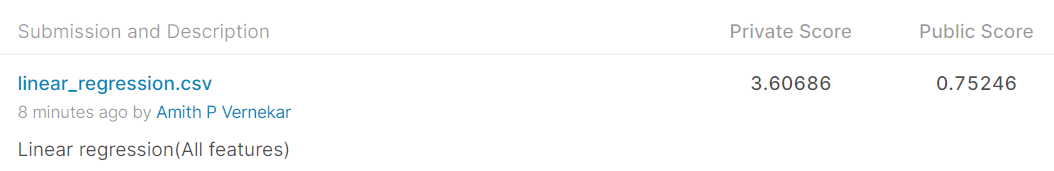

In [8]:
Image(filename="1.1.png")

## 1.2. Linear regression without lagging features

In [191]:
lags = ['lag_28','lag_30','lag_35','lag_42','lag_49','lag_56']

In [192]:
data2 = data.drop(lags,axis=1)

In [193]:
Xtrain,ytrain,Xval,yval,Xtest=train_val_test_split(data2)

Train dataset (12592370, 22) (12592370,)
Validation dataset (853720, 22) (853720,)
Test dataset (853720, 22)


In [194]:
model = LinearRegression(n_jobs=-1)
model.fit(Xtrain,ytrain)
ypred = model.predict(Xval)
rmse = mse(yval,ypred)
print("The validation RMSE score is ",rmse)

The validation RMSE score is  3.769212


In [195]:
generate_submission_file(model,Xval,Xtest,"linear_regression2.csv")

Submission file with name linear_regression2.csv created successfully


In [196]:
!kaggle competitions submit -c m5-forecasting-accuracy -f linear_regression2.csv -m "Linear regression(without lag features)"

100%|██████████████████████████████████████| 19.0M/19.0M [00:00<00:00, 42.0MB/s]
Successfully submitted to M5 Forecasting - Accuracy

## Kaggle submission result


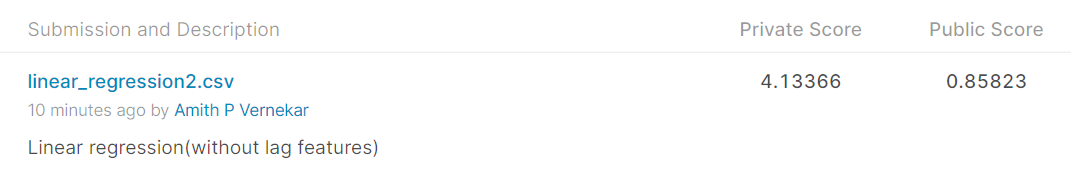

In [9]:
Image(filename="1.2.png")

## 1.3. Linear Regression without rolling features

In [27]:
rolling = ['rolling_median_7','rolling_median_14','rolling_median_28']

In [28]:
data3 = data.drop(rolling,axis=1)

In [10]:
Xtrain,ytrain,Xval,yval,Xtest=train_val_test_split(data3)

Train dataset (12592370, 25) (12592370,)
Validation dataset (853720, 25) (853720,)
Test dataset (853720, 25)


In [152]:
model = LinearRegression(n_jobs=-1)
model.fit(Xtrain,ytrain)
ypred = model.predict(Xval)
rmse = mse(yval,ypred)
print("The validation RMSE score is ",rmse)

The validation RMSE score is  5.2231703


In [153]:
generate_submission_file(model,Xval,Xtest,"linear_regression3.csv")

Submission file with name linear_regression3.csv created successfully


In [154]:
!kaggle competitions submit -c m5-forecasting-accuracy -f linear_regression3.csv -m "Linear regression(without rolling_median features)"

100%|██████████████████████████████████████| 18.5M/18.5M [00:00<00:00, 40.2MB/s]
Successfully submitted to M5 Forecasting - Accuracy

## Kaggle submission result

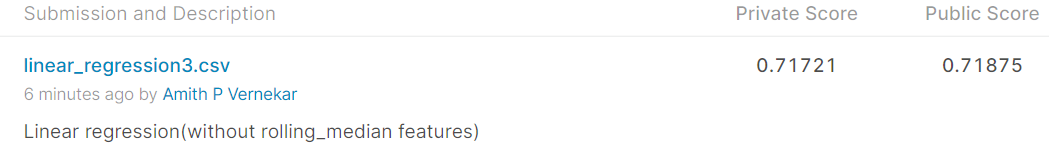

In [10]:
Image(filename="1.3.png")

## 2.RIDGE REGRESSION

### 2.1 Ridge Regression(All  features)

In [209]:
Xtrain,ytrain,Xval,yval,Xtest=train_val_test_split(data)

Train dataset (12592370, 28) (12592370,)
Validation dataset (853720, 28) (853720,)
Test dataset (853720, 28)


In [210]:
model = linear_model.Ridge()
model.fit(Xtrain,ytrain)
ypred = model.predict(Xval)
rmse = mse(yval,ypred)
print("The validation RMSE score is ",rmse)

The validation RMSE score is  3.639339


In [211]:
generate_submission_file(model,Xval,Xtest,"ridge1.csv")

Submission file with name ridge1.csv created successfully


In [212]:
!kaggle competitions submit -c m5-forecasting-accuracy -f ridge1.csv -m "Ridge Regression model(All features)"

100%|██████████████████████████████████████| 18.9M/18.9M [00:00<00:00, 36.7MB/s]
Successfully submitted to M5 Forecasting - Accuracy

## Kaggle submission result

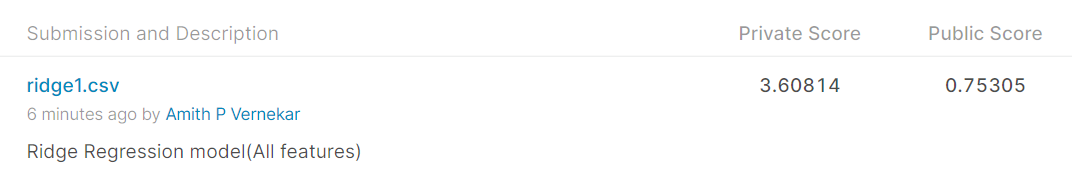

In [11]:
Image(filename="3.1.png")

### 2.2 Ridge Regression(Excluding rolling features)

In [213]:
Xtrain,ytrain,Xval,yval,Xtest=train_val_test_split(data3)

Train dataset (12592370, 25) (12592370,)
Validation dataset (853720, 25) (853720,)
Test dataset (853720, 25)


In [214]:
model = linear_model.Ridge()
model.fit(Xtrain,ytrain)
ypred = model.predict(Xval)
rmse = mse(yval,ypred)
print("The validation RMSE score is ",rmse)

The validation RMSE score is  5.2232246


In [215]:
generate_submission_file(model,Xval,Xtest,"ridge3.csv")

Submission file with name ridge3.csv created successfully


In [217]:
!kaggle competitions submit -c m5-forecasting-accuracy -f ridge3.csv -m "Ridge Regression model(without rolling_median features)"

100%|██████████████████████████████████████| 18.5M/18.5M [00:00<00:00, 41.8MB/s]
Successfully submitted to M5 Forecasting - Accuracy

## Kaggle submission result

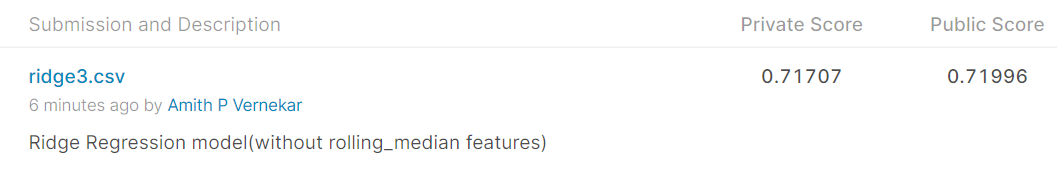

In [12]:
Image(filename="3.3.png")

## 3. LASSO REGRESSION

In [29]:
Xtrain,ytrain,Xval,yval,Xtest=train_val_test_split(data3)

Train dataset (12592370, 25) (12592370,)
Validation dataset (853720, 25) (853720,)
Test dataset (853720, 25)


In [31]:
model = LinearRegression()
model.fit(Xtrain,ytrain)
ypred = model.predict(Xval)
rmse = mse(yval,ypred)
print("The validation RMSE score is ",rmse)

The validation RMSE score is  5.4212236


In [32]:
generate_submission_file(model,Xval,Xtest,"lasso3.csv")

Submission file with name lasso3.csv created successfully


In [33]:
!kaggle competitions submit -c m5-forecasting-accuracy -f lasso3.csv -m "Lasso regression(without rolling_median features)"

100%|██████████████████████████████████████| 18.4M/18.4M [00:00<00:00, 43.3MB/s]
Successfully submitted to M5 Forecasting - Accuracy

## Kaggle submission result

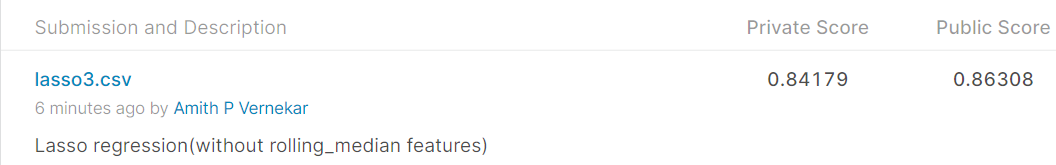

In [13]:
Image(filename="31.3.png")

## 4.BAYESIAN RIDGE REGRESSION

### 4.1 Bayesian Ridge Regression(All features)

In [197]:
Xtrain,ytrain,Xval,yval,Xtest=train_val_test_split(data)

Train dataset (12592370, 28) (12592370,)
Validation dataset (853720, 28) (853720,)
Test dataset (853720, 28)


In [198]:
model = linear_model.BayesianRidge()
model.fit(Xtrain,ytrain)
ypred = model.predict(Xval)
rmse = mse(yval,ypred)
print("The validation RMSE score is ",rmse)

The validation RMSE score is  3.6392924247003626


In [199]:
generate_submission_file(model,Xval,Xtest,"bayesian_ridge.csv")

Submission file with name bayesian_ridge.csv created successfully


In [200]:
!kaggle competitions submit -c m5-forecasting-accuracy -f bayesian_ridge.csv -m "Bayesian Ridge Regression model(All features)"

100%|██████████████████████████████████████| 33.1M/33.1M [00:00<00:00, 49.7MB/s]
Successfully submitted to M5 Forecasting - Accuracy

## Kaggle submission result

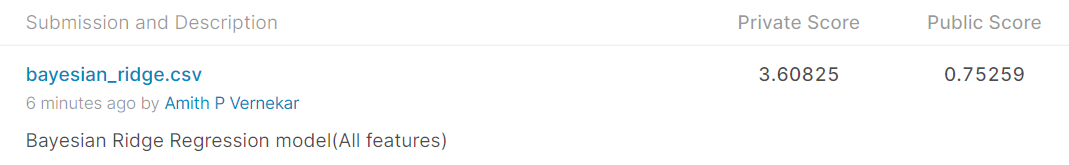

In [14]:
Image(filename="2.1.png")

### 4.2 Bayesian Ridge Regression(Excluding Lag features features)

In [201]:
Xtrain,ytrain,Xval,yval,Xtest=train_val_test_split(data2)

Train dataset (12592370, 22) (12592370,)
Validation dataset (853720, 22) (853720,)
Test dataset (853720, 22)


In [202]:
model = linear_model.BayesianRidge()
model.fit(Xtrain,ytrain)
ypred = model.predict(Xval)
rmse = mse(yval,ypred)
print("The validation RMSE score is ",rmse)

The validation RMSE score is  3.76920407849122


In [203]:
generate_submission_file(model,Xval,Xtest,"bayesian_ridge2.csv")

Submission file with name bayesian_ridge2.csv created successfully


In [204]:
!kaggle competitions submit -c m5-forecasting-accuracy -f bayesian_ridge2.csv -m "Bayesian Ridge Regression model(without lag features)"

100%|██████████████████████████████████████| 33.2M/33.2M [00:00<00:00, 41.2MB/s]
Successfully submitted to M5 Forecasting - Accuracy

## Kaggle submission result

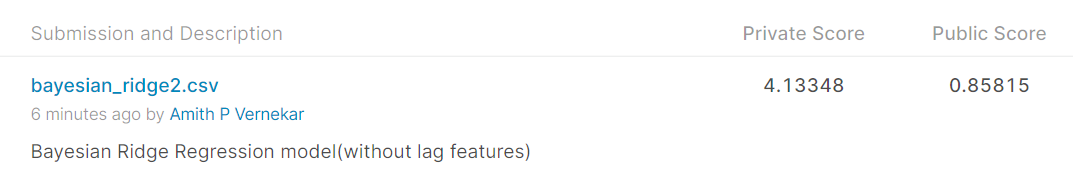

In [15]:
Image(filename="2.2.png")

### 4.3 Bayesian Ridge Regression(Excluding Rolling_median features features)

In [205]:
Xtrain,ytrain,Xval,yval,Xtest=train_val_test_split(data3)

Train dataset (12592370, 25) (12592370,)
Validation dataset (853720, 25) (853720,)
Test dataset (853720, 25)


In [206]:
model = linear_model.BayesianRidge()
model.fit(Xtrain,ytrain)#m3
ypred = model.predict(Xval)
rmse = mse(yval,ypred)
print("The validation RMSE score is ",rmse)

The validation RMSE score is  5.223194276226635


In [207]:
generate_submission_file(model,Xval,Xtest,"bayesian_ridge3.csv")

Submission file with name bayesian_ridge3.csv created successfully


In [208]:
!kaggle competitions submit -c m5-forecasting-accuracy -f bayesian_ridge3.csv -m "Bayesian Ridge Regression model(without rolling_median features)"

100%|██████████████████████████████████████| 32.7M/32.7M [00:00<00:00, 40.4MB/s]
Successfully submitted to M5 Forecasting - Accuracy

## Kaggle submission result

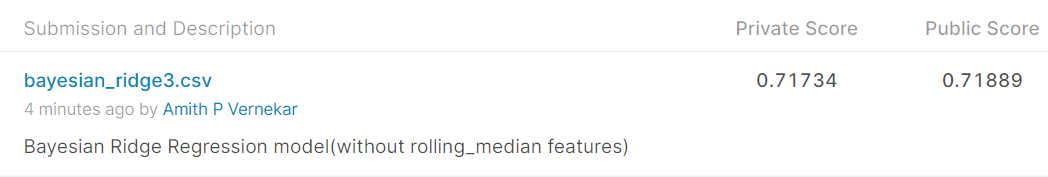

In [16]:
Image(filename="2.3.png")

## 5. ELASTIC NET

In [2]:
data = pd.read_pickle('formated_data.pkl')
data = data[data['day']>1500]

### Elastic Net(without rolling median features)

In [21]:
Xtrain,ytrain,Xval,yval,Xtest=train_val_test_split(data3)

Train dataset (12592370, 25) (12592370,)
Validation dataset (853720, 25) (853720,)
Test dataset (853720, 25)


In [25]:
alpha = [0.00001,0.0001,0.01,0.1,1,10,100]
rmses=[]
for i in alpha: 
    model = linear_model.ElasticNet(alpha=i,max_iter=100)
    model.fit(Xtrain,ytrain)
    ypred = model.predict(Xval)
    rmse = mse(yval,ypred)
    rmses.append(rmse)

Optimal alpha is  1e-05


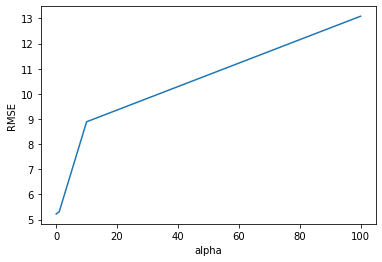

In [26]:
import matplotlib.pylab as plt
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.plot(alpha,rmses)
print("Optimal alpha is ",alpha[np.argmin(rmses)])

In [27]:
model = linear_model.ElasticNet(alpha=0.00001,max_iter=100)
model.fit(Xtrain,ytrain)
ypred = model.predict(Xval)
rmse = mse(yval,ypred)
print("The validation RMSE score is ",rmse)

The validation RMSE score is  5.223564


In [28]:
generate_submission_file(model,Xval,Xtest,"elasticnet3.csv")

Submission file with name elasticnet3.csv created successfully


In [29]:
!kaggle competitions submit -c m5-forecasting-accuracy -f elasticnet3.csv -m "Elastic Net model(Without rolling_median features)"

100%|██████████████████████████████████████| 18.5M/18.5M [00:00<00:00, 47.2MB/s]
Successfully submitted to M5 Forecasting - Accuracy

## Kaggle submission result

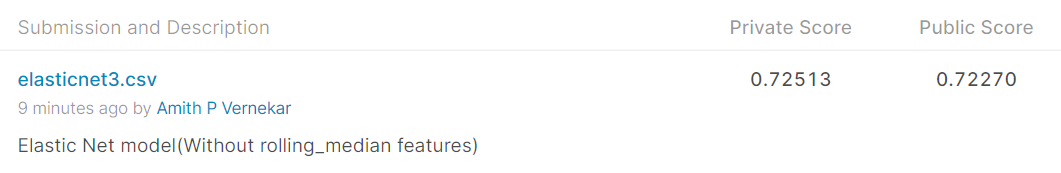

In [17]:
Image(filename="4.png")

## 6. LEAST ANGLE REGRESSION

In [30]:
Xtrain,ytrain,Xval,yval,Xtest=train_val_test_split(data3)

Train dataset (12592370, 25) (12592370,)
Validation dataset (853720, 25) (853720,)
Test dataset (853720, 25)


In [32]:
alpha = [0.00001,0.0001,0.01,0.1,1,10,100]
rmses=[]
for i in alpha: 
    model = linear_model.LassoLars(alpha=i)
    model.fit(Xtrain,ytrain)
    ypred = model.predict(Xval)
    rmse = mse(yval,ypred)
    rmses.append(rmse)

Optimal alpha is  1e-05


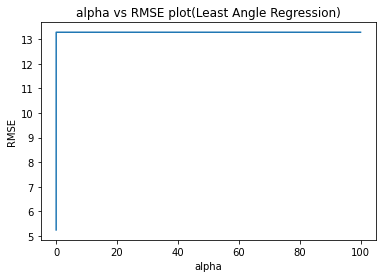

In [38]:
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.title('alpha vs RMSE plot(Least Angle Regression)')
plt.plot(alpha,rmses)
print("Optimal alpha is ",alpha[np.argmin(rmses)])

In [34]:
model = linear_model.LassoLars(alpha=0.00001)
model.fit(Xtrain,ytrain)
ypred = model.predict(Xval)
rmse = mse(yval,ypred)
print("The validation RMSE score is ",rmse)

The validation RMSE score is  5.242562653123173


In [35]:
generate_submission_file(model,Xval,Xtest,"lar3.csv")

Submission file with name lar3.csv created successfully


In [36]:
!kaggle competitions submit -c m5-forecasting-accuracy -f lar3.csv -m "Least Angle Regression(Without rolling_median features)"

100%|██████████████████████████████████████| 32.7M/32.7M [00:00<00:00, 60.8MB/s]
Successfully submitted to M5 Forecasting - Accuracy

## Kaggle submission result

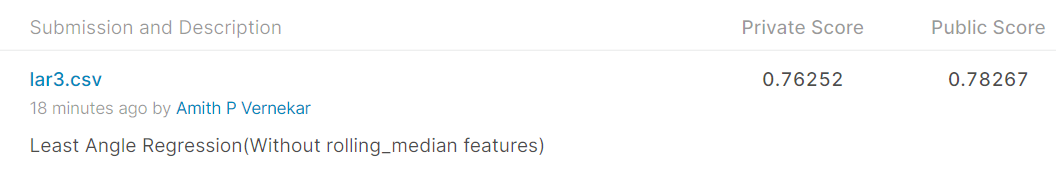

In [18]:
Image(filename="5.png")

## SUMMARY

* Took past 15 months data(starting from day 1500)
* Models trained with features excluding rolling_median features performed well. 
* <b>Various basic models trained excluding rolling_median features are as follows.</b>

||Model name|Private Score| Public Score
|--|--|--|--|
|1|Linear Regression|0.71721|0.71875|
|2|Ridge Regression|0.71707|0.7196|
|3|Lasso Regression|0.84179|0.86308|
|4|Bayesian Ridge Regression|0.71734|0.71889|
|5|ElasticNet|0.72513|0.72270|
|6|Least Angle Regression|0.76252|0.78267|
|<b>7</b>|<b>Lightgbm Regression</b>|<b>0.66509</b>|<b>0.65114</b>|
|8|Catboost Regression|0.68284|0.69701|

* Among all the trained models, Ridge Regression model performed well.